In [10]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

In [11]:
from typing import Tuple

outputs_path = Path("../outputs")


def load_scenario_data(name: str = None) -> Tuple[pd.DataFrame, pd.DataFrame]:
    name = "current" if name is None else name
    scenario_path = outputs_path / name
    scenario_data_path = scenario_path / "data"

    print(f"Using Scenario path: {scenario_path}")
    trips_df: pd.DataFrame = None
    route_times = []
    elapsed_times = []
    for path in scenario_data_path.iterdir():
        if not path.is_dir():
            continue

        try:
            scenario_df = pd.read_csv(path / "trips.csv", skipinitialspace=True)
            trips_df = pd.concat([trips_df, scenario_df], ignore_index=True)

            with open(path / "results.txt", "r") as f:
                lines = f.readlines()
                route_times.append(float(lines[3].split()[2]))
                elapsed_times.append(float(lines[5].split()[2]))

        except Exception:
            pass

    env = ""
    with open(scenario_path / ".conf", "r") as f:
        env = "".join(f.readlines())

    ran_at = ""
    with open(scenario_path / ".run_at", "r") as f:
        ran_at = f.readline()

    routes_df = pd.DataFrame(
        {"ROUTE_TIMES": route_times, "ELAPSED_TIMES": elapsed_times}
    )

    return (trips_df, routes_df, env, ran_at)

In [12]:
trips, route_results, env, ran_at = load_scenario_data("2024-06-17_21:21:40")
scenario_name = "Scenario"
print("Ran At: ", ran_at)

Using Scenario path: ../outputs/2024-06-17_21:21:40
Ran At:  2024-06-17_21:21:40



In [13]:
print(env)

# Copy this file to queues/active and customize it
# You can have multiple .conf files in the queue folder as per each type of simulation

SCENARIO=Zero # One of [Zero|One|AllBelowCutoff]
OUTPUT_DIR=outputs/current

LAMBDA_PARAM=0.1  # float
PLANNING_HORIZON=0.7  # float

SHUTTLE_SPEED=0.00556 # the shuttle moves with a constant speed of x units of distance/sec

# All these must be Integers, use _ for separation instead of commas
RESERVATION_CUTOFF=50
NUMBER_OF_ZONES_PER_ROW=10
ZONE_LENGTH=1
ZONE_WIDTH=1
NUM_OF_SIMULATIONS=3


In [14]:
from models import ReservationStatus

trips.loc[trips.RESERVATION_STATUS == str(ReservationStatus.REJECTED)]

,ID,DIRECTION,LOCATION_INDEX,RESERVED_AT,RESERVATION_STATUS
1,2,INBOUND,39,36,REJECTED
5,6,OUTBOUND,25,53,REJECTED
6,7,INBOUND,57,12,REJECTED
10,1,OUTBOUND,41,50,REJECTED
12,3,OUTBOUND,4,58,REJECTED
15,6,INBOUND,13,3,REJECTED
20,1,INBOUND,5,10,REJECTED
23,4,OUTBOUND,84,20,REJECTED
26,7,OUTBOUND,98,11,REJECTED
29,10,OUTBOUND,16,59,REJECTED


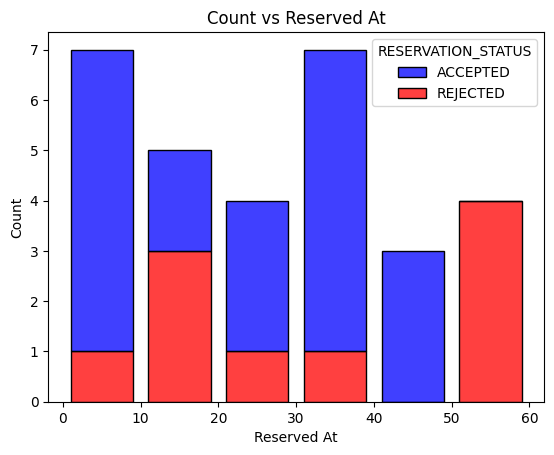

In [15]:
import seaborn as sns

colors = {"ACCEPTED": "blue", "REJECTED": "red"}

# Use seaborn to create the bar plot
trips_df = trips
sns.histplot(
    data=trips_df,
    x="RESERVED_AT",
    hue="RESERVATION_STATUS",
    multiple="stack",
    palette=colors,
    shrink=0.8,
    bins=range(0, 70, 10),
)
plt.xlabel("Reserved At")
plt.ylabel("Count")
plt.title("Count vs Reserved At")
plt.show()

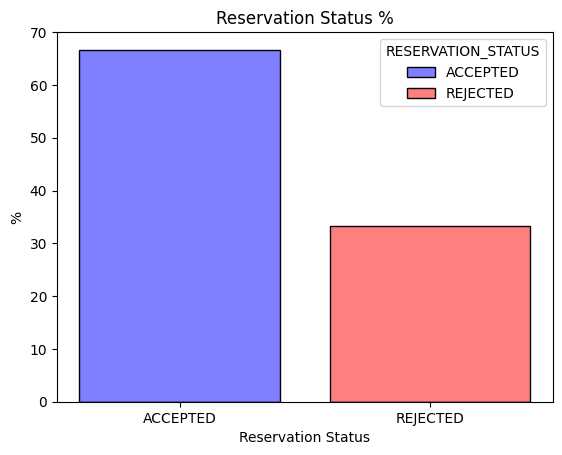

In [16]:
colors = {"ACCEPTED": "blue", "REJECTED": "red"}
sns.histplot(
    data=trips_df,
    x="RESERVATION_STATUS",
    stat="percent",
    hue="RESERVATION_STATUS",
    palette=colors,
    shrink=0.8,
    bins=range(0, 61, 5),
)

plt.xlabel("Reservation Status")
plt.ylabel("%")
plt.title("Reservation Status %")
plt.show()

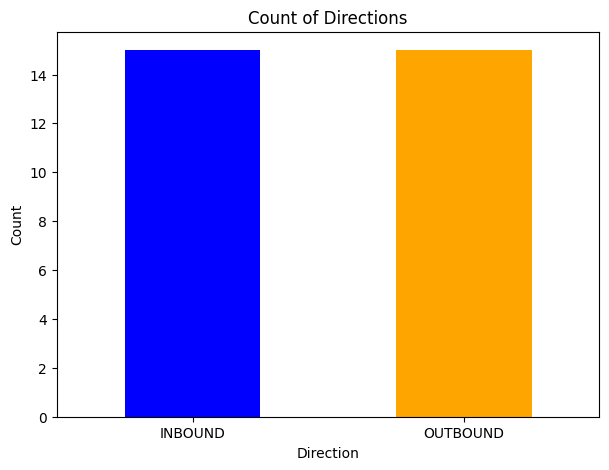

In [17]:
trips_df = trips
direction_counts = trips_df["DIRECTION"].value_counts()
plt.figure(figsize=(7, 5))
direction_counts.plot(kind="bar", color=["blue", "orange"])
plt.xlabel("Direction")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.title("Count of Directions")
plt.show()

In [18]:
def plot_kde_for(df, x: str, hue: str = None, pallete: list = None):
    sns.kdeplot(
        data=df,
        x=x,
        hue=hue,
        fill=True,
        common_norm=False,
        palette=pallete,
        alpha=0.5,
        linewidth=0,
    )


routes_df = None
scenario_routes_df = route_results
scenario_routes_df["NAME"] = scenario_name
routes_df = pd.concat([routes_df, scenario_routes_df], ignore_index=True)

# plot_kde_for(routes_df, "ROUTE_TIMES", "NAME", ["red", "blue"])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Route times (Minutes)')

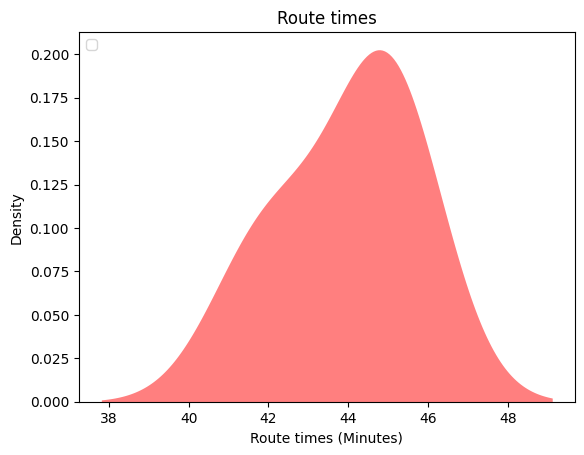

In [19]:
plot_kde_for(scenario_routes_df, "ROUTE_TIMES", "NAME", ["red"])
plt.title(f"Route times")
plt.legend(loc="upper left")
plt.xlabel("Route times (Minutes)")

Text(0.5, 0, 'Elapsed time (Seconds)')

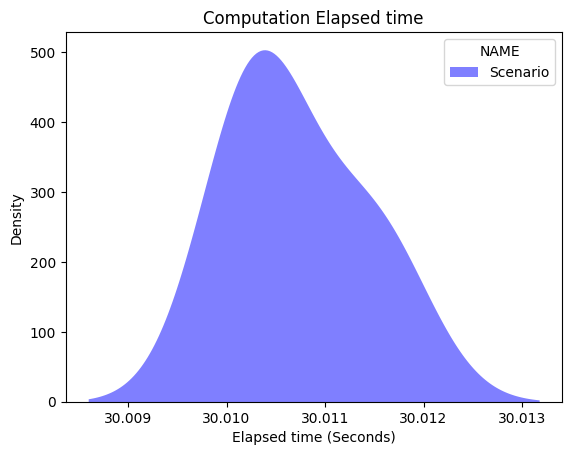

In [20]:
plot_kde_for(scenario_routes_df, "ELAPSED_TIMES", "NAME", ["blue"])
plt.title(f"Computation Elapsed time")
plt.xlabel("Elapsed time (Seconds)")

/tmp/ipykernel_10825/2493066041.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(


<Axes: xlabel='ROUTE_TIMES', ylabel='Count'>

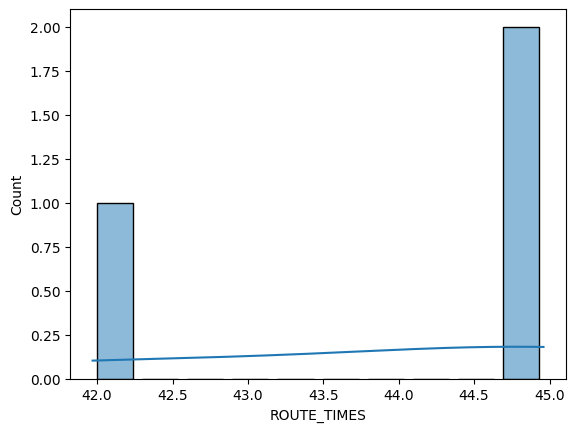

In [21]:
sns.histplot(
    data=scenario_routes_df,
    x="ROUTE_TIMES",
    palette=colors,
    stat="count",
    shrink=0.8,
    bins=10,
    common_norm=False,
    kde=True,
)

In [22]:
# scenario_one_routes_df = routes_df[routes_df["NAME"] == "ScenarioOne"]

# plot_kde_for(scenario_one_routes_df, "ROUTE_TIMES", "NAME", ["blue"])
# plt.title("When Reservations' T >= 50 are considered")
# plt.legend(loc="upper left")

In [23]:
import numpy as np

# Calculate the mean and variance for each column
mean = np.mean(route_results["ROUTE_TIMES"], axis=0)
variance = np.var(route_results["ROUTE_TIMES"], axis=0)

print("Mean Route time: ", mean, " minutes")
print("Route time Variance: ", variance, " minutes")

Mean Route time:  43.96333333333333  minutes
Route time Variance:  1.9866888888888914  minutes
